# Geokr

## Get config

In [1]:
import json

with open('.config') as fp:
    config = json.load(fp)

## Flickr class

In [2]:
import requests
import json
import io

'''
This class allow sending http request on Flickr API. The Json result is automaticcally parsed.
'''
class Flickr:
    request_baseurl = 'https://api.flickr.com/services/rest/'
    jsonDecoder = json.JSONDecoder()
    
    '''
    Flickr constructor
    
    @param stirng api_key - Your Flickr API key
    '''
    def __init__(self, api_key):
        
        
        self.api_key = api_key

    def request(self, method, args):
        url = self.request_baseurl + '?api_key=' + self.api_key + '&format=json&method=' + method + '&' + '&'.join([k+'='+str(v) for k,v in args.iteritems()])
        return self.jsonDecoder.decode(requests.get(url).content[len("jsonFlickrApi("):-1])
    
    def doRequest(self, offset, nb_page, method, args):
        data=[]
        for page in range(nb_page):
            args['page'] = offset + page + 1
            print "fetching page number %d/%d (%d photos) " % ((page+1), nb_page, len(data))
            data += flickr.request(method, args)["photos"]["photo"]
            
        print "fetching end Total : %s photos requested" % (len (data))
        return data

    def saveData(self, data, save_file):
        with io.open(save_file, 'w', encoding='utf-8') as f:
            f.write(unicode(json.dumps(data,indent=4, ensure_ascii=False)))
        print '%s lines of data saved to %s' %(len(data), save_file)
        
    def loadDataFromFile(self, load_file):
        with open(load_file) as photos_json:
            return json.load(photos_json)

flickr = Flickr(config['API_KEY'])

## Get photos

In [3]:
data = flickr.loadDataFromFile('dataTest.json')

# KMeans

### Get the coordinates from data

In [4]:
import numpy as np

coordinates = []

for photo in data:
    if photo["latitude"] != 0 and photo["longitude"] != 0:
        coordinates += [[photo["latitude"], photo["longitude"]]]

print "%d coordonnées" % len(coordinates)

coordinates = np.array(coordinates, dtype=float)

5115 coordonnées


### Run the algorithm

In [5]:
from scipy.cluster.vq import kmeans2

k = 10
i = 500

centroids, closest_centroids = kmeans2(coordinates, k, iter=i)

print centroids

[[ -22.25782793  -52.29429998]
 [   7.72990515  108.36067313]
 [  34.49374389  -82.21316489]
 [ -35.14290435  151.8262919 ]
 [  38.89525791 -119.26850161]
 [  12.81623644   62.68351697]
 [  49.55895023   12.14365355]
 [  42.32399231   33.88836663]
 [  31.55496662  128.73594621]
 [  48.27810356   -1.93845393]]


### Filter by density

In [6]:
densities = [0] * k

for closest_centroid in closest_centroids:
    densities[closest_centroid - 1] += 1
    
print densities

filteredCentroids = centroids.tolist()

for i in range(len(densities) - 1, -1, -1):
    if densities[i] < 3 * len(data) / 100:
        filteredCentroids.remove(filteredCentroids[i])

filteredCentroids = np.array(filteredCentroids, dtype=float)
print filteredCentroids

[365, 1192, 157, 633, 173, 768, 206, 272, 971, 378]
[]


## Plot

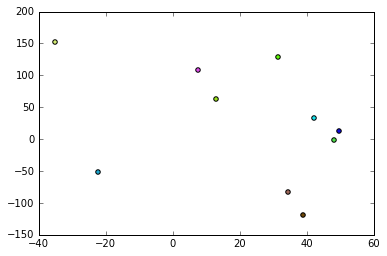

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

for centroid in centroids:
    plt.scatter(centroid[0], centroid[1], c=np.random.rand(3,1))
    
plt.show()

In [8]:
import folium
from IPython.display import HTML

def inline_map(m, width=800, height=600):
    """Takes a folium instance and embed HTML."""
    
    srcdoc = m._repr_html_().replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed


width, height = 800, 600
radars = folium.Map(location=[40, -122], zoom_start=1,
                    tiles='OpenStreetMap', width=width, height=height)

for centroid in centroids:
    folium.Marker([centroid[0], centroid[1]], ).add_to(radars) 



inline_map(radars)

### DBSCAN

In [9]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=10,min_samples=40).fit(coordinates)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print 'Estimated number of clusters: %d' % n_clusters_
print "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(coordinates, db.labels_)

print "%d labels" % len(db.labels_)
print "%d coordinates" % len(coordinates)

Estimated number of clusters: 6
Silhouette Coefficient: 0.632
5115 labels
5115 coordinates


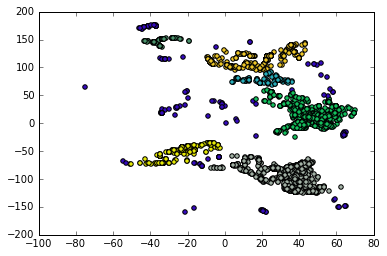

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

colors = [np.random.rand(3,1) for i in range(n_clusters_+1)]

i = 0
for label in db.labels_:
    plt.scatter(coordinates[i][0], coordinates[i][1], c=colors[(label+1)])
    i += 1
    
plt.show()

In [11]:
flickr = Flickr(config['API_KEY'])
photos = []
nb_page = 2
method = 'flickr.photos.search'
args = {
    'has_geo': 1,
    'per_page': 250,
    'extras': 'description,license,date_upload,date_taken,owner_name,icon_server,original_format,last_update,geo,tags,machine_tags,o_dims,views,media'
}

import json

for page in range(nb_page):
    args['page'] = page + 1
    photos += flickr.request(method, args)["photos"]["photo"]

                      centroid  count
0  3179.46666667-4508.66666667     15
1              5733.75-3670.25     12
2  4315.54878049-2885.26829268     82
3  1465.73913043-998.456521739     46
4  2280.97777778-2279.33333333     45
5          3299.875-2462.21875     64


//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
A variable was mapped to y.
    stat_bin sets the y value to the count of cases in each group.
    The mapping to y was ignored.
    If you want y to represent values in the data, use stat="bar".


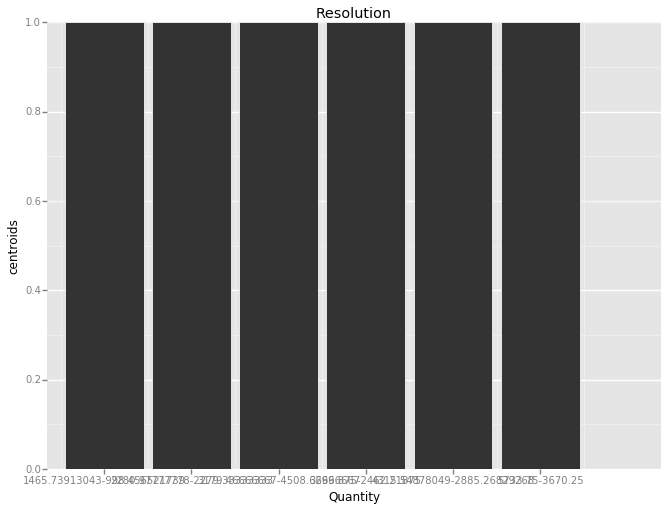

<ggplot: (277892441)>

In [12]:
from ggplot import *
import pandas as pd

dims = [[photo['o_width'],photo['o_height']] for photo in photos if photo.has_key('o_width') and photo.has_key('o_height')]

import numpy as np
from scipy.cluster.vq import kmeans2

k = 6
i = 500

centroids, closest_centroids = kmeans2(np.array(dims, dtype=float), k, iter=i)
count = [len([c for c in closest_centroids if c == i]) for i in range(len(centroids))];

df = pd.DataFrame({
    "count" : count,
    "centroid" : [str(c[0]) + "-" + str(c[1]) for c in centroids]
})

print df

ggplot(df, aes(x='centroid',y='count')) + geom_bar() + ggtitle("Resolution") + labs("Quantity", "centroids")

## Convert centroids to GeoJSON

In [13]:
import json

def getFeature(coordinates):
    return {
        "type": "Feature",
        "properties" : {},
        "geometry" : {
            "type" : "Point",
            "coordinates" : [coordinates[1], coordinates[0]]
        }
    }

features = [getFeature(coordinates) for coordinates in centroids]

geoJson = {
    "type" : "FeatureCollection",
    "features" : features
}

print json.dumps(geoJson)

{"type": "FeatureCollection", "features": [{"geometry": {"type": "Point", "coordinates": [4508.666666666667, 3179.4666666666667]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [3670.25, 5733.75]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [2885.268292682927, 4315.5487804878048]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [998.45652173913038, 1465.7391304347825]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [2279.3333333333335, 2280.9777777777776]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [2462.21875, 3299.875]}, "type": "Feature", "properties": {}}]}
